In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import networkx as nx
import scipy.sparse as sp
import numpy as np
from math import sqrt

# [DeltaCon](http://arxiv.org/pdf/1304.4657v1.pdf)


In [45]:
def compute_FBP_invs(A):

    # max power to calculate inverse to
    max_pw = 7

    # make identity
    I = sp.identity(A.shape[0])
 
    # remove self links - can't propogate beliefs to self - need to consider if the self links should be counted in
    # degree still?
    A = A - sp.dia_matrix((A.diagonal(), [0]), shape=(A.shape[0], A.shape[0]))

    # make degree matrix
    ds = [int(x) for x in A.sum(axis=1)]
    D = sp.dia_matrix((ds, [0]),
                     shape=(len(ds), len(ds)))
    
    # compute about-half homophility factor that gaurentees convergences of W power series
    c1 = D.sum() + 2
    c2 = np.dot(D,D).sum() - 1
    h_h = sqrt((-c1+sqrt(c1**2 + 4*c2))
               /(8*c2)
              )
    
    # compute system constants ah (from ahD) and ch from (achA)
    ah = 4*(h_h**2) /(1-4*(h_h**2))
    ch = 2*h_h / (1-4*(h_h**2))
    
    # create matrix M to form (I - M)^-1
    M = ch*A - ah*D
    
    # expand to power series to compute inverse
    inv = I
    mat = M
    pwr = 1
    while mat.data[mat.data.argmax()] > 10**(-9) and pwr < max_pw:
        inv = inv + mat
        mat = mat * M
        pwr = pwr + 1
    return inv

In [46]:
def DeltaCon(A1, A2):
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon)
    p = 0.501
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    
    ######## BAD: this is matrix multiplication not element-wise squaring! ######
    diffM = (inv1.sqrt() - inv2.sqrt()) ** 2
    
    
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = diffM - sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))
    return 1 / (1 + sqrt(diffM.sum()))

In [47]:
def DeltaCon_test(A1, A2):
    
    # initialize
    # prior belief for nodes (doesn't really affect results of deltacon)
    p = 0.501
    
    # Solve the linear BP systems (FaBP): inv corresponds to [I + ah*D - ch*A]^-1
    # and multiple by about-half prior beliefs
    inv1 = compute_FBP_invs(A1) * (p-0.5)
    inv2 = compute_FBP_invs(A2) * (p-0.5)
    
    # compute the similarities using Matusita distance
    diffM = (inv1.sqrt() - inv2.sqrt()) ** 2
    # delete diagonal entries -  the influence nodes have on themselves
    diffM = sp.dia_matrix((diffM.diagonal(), [0]), shape=(diffM.shape[0], diffM.shape[0]))
    return 1 / (1 + sqrt(diffM.sum()))

# Testing

In [48]:
Abb = nx.adjacency_matrix(nx.barbell_graph(10,0))
DeltaCon_test(Abb, Abb)

1.0

In [49]:
AB10 = nx.adjacency_matrix(nx.barbell_graph(5,0))
mB10 = nx.barbell_graph(5,0)
mB10.remove_edge(5,6)
mmB10 = nx.barbell_graph(5,0)
mmB10.remove_edge(4,5)
print DeltaCon(AB10, nx.adjacency_matrix(mB10))
print DeltaCon(nx.adjacency_matrix(mB10), AB10)
print DeltaCon(AB10, nx.adjacency_matrix(mmB10))
print DeltaCon(nx.adjacency_matrix(mB10), AB10) - DeltaCon(AB10, nx.adjacency_matrix(mmB10))
# differnce in paper for DeltaCon_0 is 0.07...

0.985413078148
0.985413078148
0.946279360712
0.039133717436


In [50]:
# create L10
L10 = nx.complete_graph(5)
L10.add_path([0,5,6,7,8,9])

# create mL10
mL10 = nx.complete_graph(5)
mL10.add_path([0,5,6,7,8,9])
mL10.remove_edge(0,1)
# create mmL10
mmL10 = nx.complete_graph(5)
mmL10.add_path([5,6,7,8,9])

print DeltaCon(nx.adjacency_matrix(L10), nx.adjacency_matrix(mL10))
print DeltaCon(nx.adjacency_matrix(mL10), nx.adjacency_matrix(L10))
print DeltaCon(nx.adjacency_matrix(L10), nx.adjacency_matrix(mmL10))
print (DeltaCon(nx.adjacency_matrix(L10), nx.adjacency_matrix(mL10))
       - DeltaCon(nx.adjacency_matrix(L10), nx.adjacency_matrix(mmL10)))
# differnce in paper for DeltaCon_0 is 0.04...

0.986100913543
0.986100913543
0.958562153261
0.0275387602819


# Graph sanity checks 

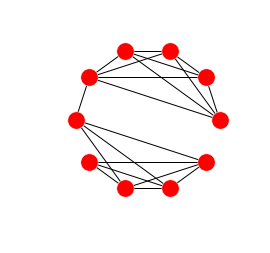

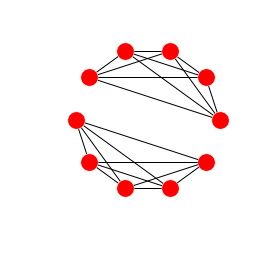

In [7]:
plt.figure(figsize=(3,3))
nx.draw_shell(mB10)
plt.figure(figsize=(3,3))
nx.draw_shell(mmB10)

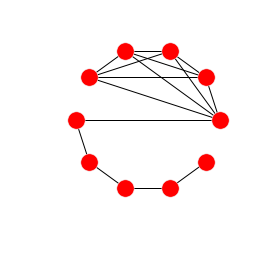

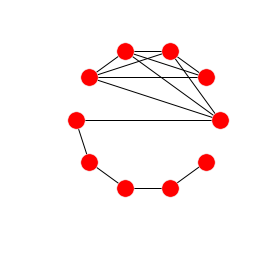

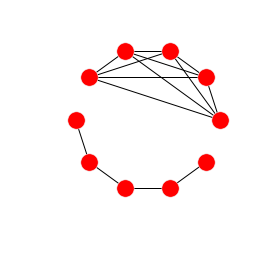

In [8]:
plt.figure(figsize=(3,3))
nx.draw_shell(L10)
plt.figure(figsize=(3,3))
nx.draw_shell(mL10)
plt.figure(figsize=(3,3))
nx.draw_shell(mmL10)